In [1]:
%matplotlib inline
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap
import matplotlib.pyplot as plt
import skimage.io as io
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

import json
from json import encoder
encoder.FLOAT_REPR = lambda o: format(o, '.3f')

In [2]:
# set up file names and pathes
dataDir='.'
dataType='val2014'
algName = 'sq_r8c2_cf'
annFile='%s/annotations/captions_%s.json'%(dataDir,dataType)
subtypes=['results', 'evalImgs', 'eval']
[resFile, evalImgsFile, evalFile]= \
['%s/results/captions_%s_%s_%s.json'%(dataDir,dataType,algName,subtype) for subtype in subtypes]

# download Stanford models
! bash get_stanford_models.sh

# download Google word2vec model
! bash get_google_word2vec_model.sh

Found Stanford CoreNLP.
Found Google news word2vec model.


In [3]:
# create coco object and cocoRes object
coco = COCO(annFile)
cocoRes = coco.loadRes(resFile)

loading annotations into memory...
0:00:00.191045
creating index...
index created!
Loading and preparing results...     
DONE (t=0.01s)
creating index...
index created!


In [4]:
# create cocoEval object by taking coco and cocoRes
cocoEval = COCOEvalCap(coco, cocoRes)

# evaluate on a subset of images by setting
# cocoEval.params['image_id'] = cocoRes.getImgIds()
# please remove this line when evaluating the full validation set
cocoEval.params['image_id'] = cocoRes.getImgIds()

# evaluate results
# SPICE will take a few minutes the first time, but speeds up due to caching
cocoEval.evaluate()

tokenization...


PTBTokenizer tokenized 6221 tokens at 62638.84 tokens per second.
PTBTokenizer tokenized 1180 tokens at 24631.25 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 967, 'reflen': 964, 'guess': [967, 867, 767, 667], 'correct': [691, 366, 152, 57]}
ratio: 1.0031120331939802
Bleu_1: 0.715
Bleu_2: 0.549
Bleu_3: 0.391
Bleu_4: 0.267
computing METEOR score...
METEOR: 0.252
computing Rouge score...
ROUGE_L: 0.525
computing CIDEr score...
CIDEr: 1.012
computing CIDEr-R score...
CIDEr-R: 1.009
computing WMD score...
WMD: 0.525


In [5]:
# print output evaluation scores
for metric, score in cocoEval.eval.items():
    print('%s: %.3f'%(metric, score))

Bleu_1: 0.715
Bleu_2: 0.549
Bleu_3: 0.391
Bleu_4: 0.267
METEOR: 0.252
ROUGE_L: 0.525
CIDEr: 1.012
CIDEr-R: 1.009
WMD: 0.525


ground truth captions
A young man wearing black attire and a flowered tie is standing and smiling.
A man with glasses and his eyes closed dressed in a black shirt and a necktie.
A man in a green tie with his eyes closed.
Smiling man wearing black shirt and pale green tie.
A person that is dressed up very nicely.


generated caption (CIDEr score 0.7)
A man wearing a tie and a shirt.


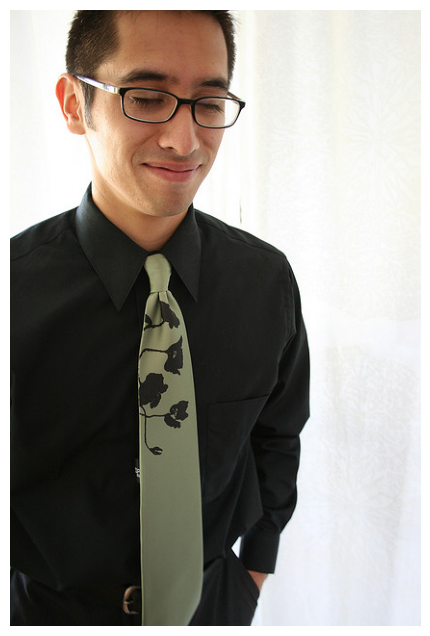

In [6]:
# demo how to use evalImgs to retrieve low score result
evals = [eva for eva in cocoEval.evalImgs if eva['CIDEr']<30]
print('ground truth captions')
imgId = evals[0]['image_id']
annIds = coco.getAnnIds(imgIds=imgId)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

print('\n')
print('generated caption (CIDEr score %0.1f)'%(evals[0]['CIDEr']))
annIds = cocoRes.getAnnIds(imgIds=imgId)
anns = cocoRes.loadAnns(annIds)
coco.showAnns(anns)

img = coco.loadImgs(imgId)[0]
I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
plt.imshow(I)
plt.axis('off')
plt.show()

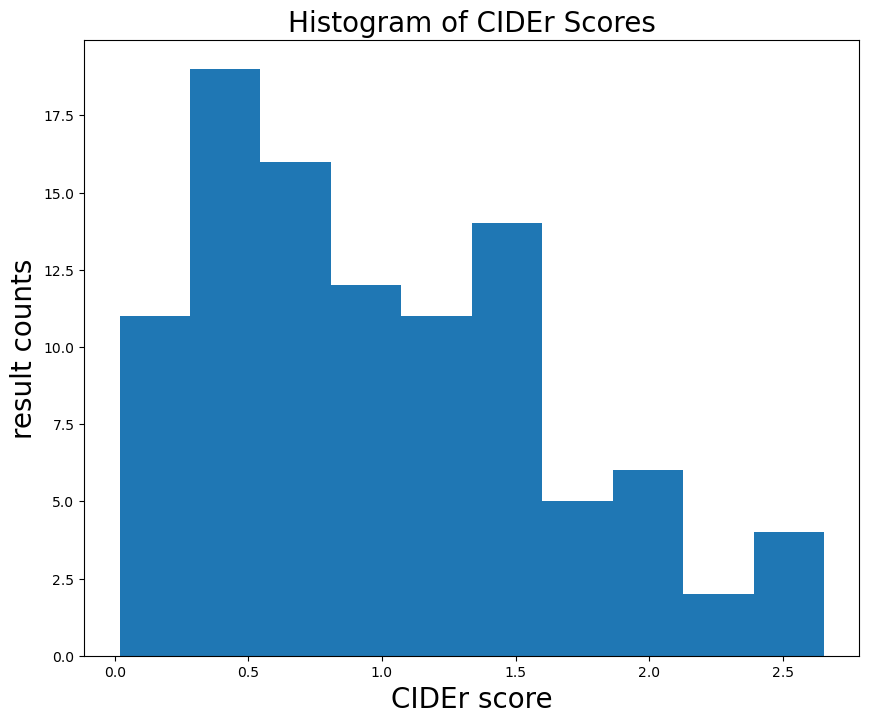

In [7]:
# plot score histogram
ciderScores = [eva['CIDEr'] for eva in cocoEval.evalImgs]
plt.hist(ciderScores)
plt.title('Histogram of CIDEr Scores', fontsize=20)
plt.xlabel('CIDEr score', fontsize=20)
plt.ylabel('result counts', fontsize=20)
plt.show()

In [8]:
# save evaluation results to ./results folder
json.dump(cocoEval.evalImgs, open(evalImgsFile, 'w'))
json.dump(cocoEval.eval,     open(evalFile, 'w'))